In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_pre_train
from going_modular.ThreeHeadCNN import ThreeHeadCNN
import helper_functions

c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
allow_train = True
freeze_encoder = False
EPOCHS = 15
BATCH_SIZE = 128
shrink_size = None

crop_size = 240

num_augs = 1
p_dropout = 0.3
lr = 0.1
weight_deacay = 1e-5
T_max = 5
eta_min = 1e-2

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms()
no_transforms = helper_functions.get_augmentation_no_transforms()

In [5]:
# load all dataloaders

exp_dataloader, class_names = custom_data_setup_pre_train.create_test_dataloader(
    transform=no_transforms,
    batch_size=BATCH_SIZE,
    shrink_size=shrink_size) 

val_dataloader, class_names = custom_data_setup_pre_train.create_test_dataloader(
    transform=test_transforms, 
    batch_size=BATCH_SIZE,
    shrink_size=shrink_size) 

train_dataloader, class_names = custom_data_setup_pre_train.create_train_dataloader(
    transform=train_transforms, 
    batch_size=BATCH_SIZE,
    shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


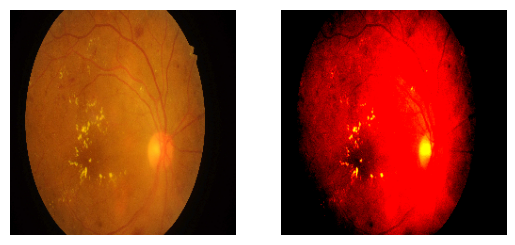

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.2489083].


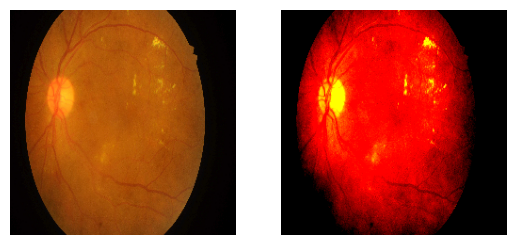

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(2):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = ThreeHeadCNN(device=device, p_dropout=p_dropout).to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(
model=model, 
input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 240, 240]    [32]                 --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

In [10]:
# Define loss and optimizer

# weights = torch.Tensor([1.87, 12.61, 4.1, 14.9, 13.12]) * 0.2
# weights.to(device)

# loss_fn_classification = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1).to(device)
# loss_fn_classification = nn.CrossEntropyLoss().to(device)
loss_fn_classification = nn.BCEWithLogitsLoss().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [ ]:
train_results = []

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    train_results, val_results = engine.pre_train(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn_classification=loss_fn_classification,
        epochs=EPOCHS,
        device=device)
        
    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='pre_train_model.pth')
else:
    model.load_state_dict(torch.load('models/pre_train_model.pth', weights_only=True, map_location=device))

 13%|█▎        | 2/15 [02:17<14:29, 66.89s/it]

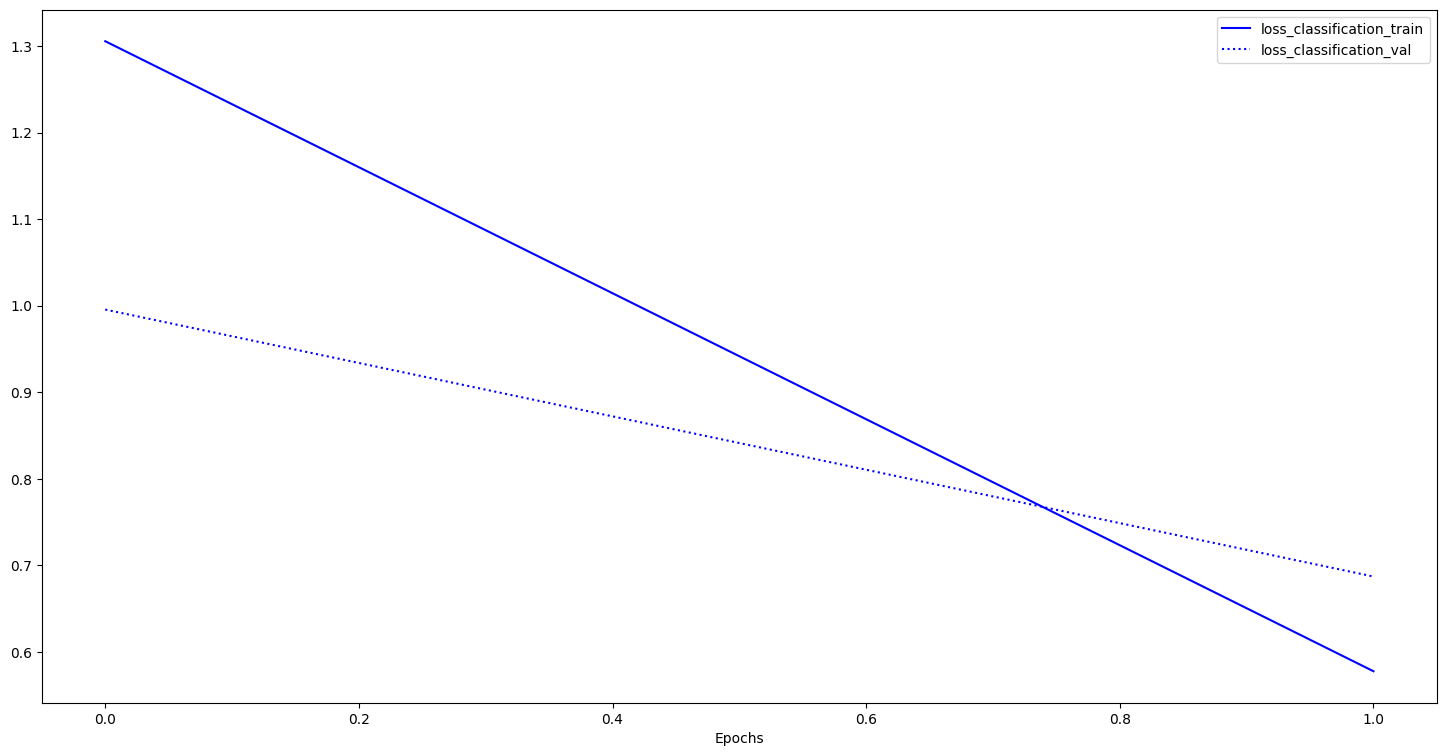

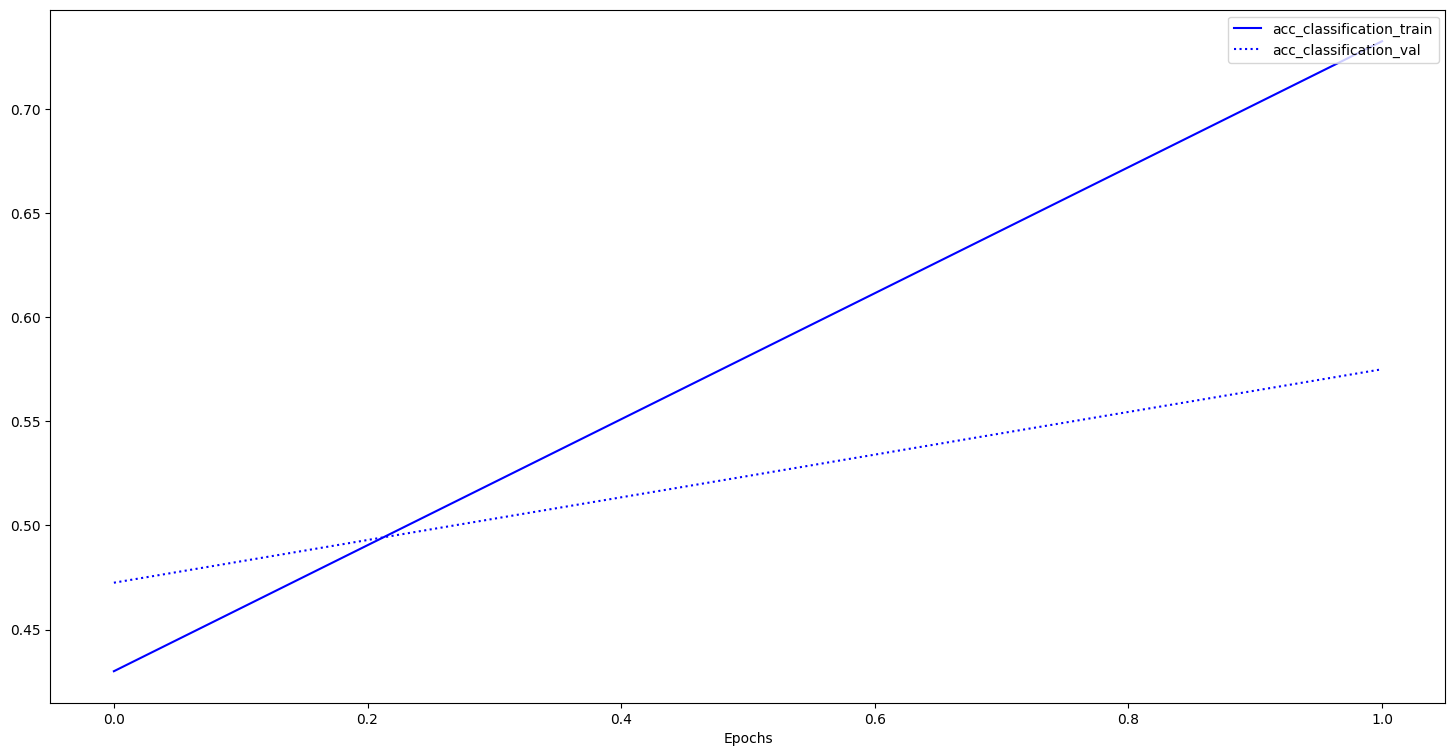

In [ ]:
if allow_train:
    helper_functions.plot_loss_curves_pre_train(train_results, val_results)
    helper_functions.plot_acc_curves(train_results, val_results)

per class scores: precision: [0.54103343 0.88732394] | recall: [0.95698925 0.29439252] | f1_score: [0.69126214 0.44210526]
average scores: precision: 0.7141786891562139 | recall: 0.625690885338157 | f1_score: 0.5666836995401124
accuracy: 0.6025
QWK:  0.2393436348849447


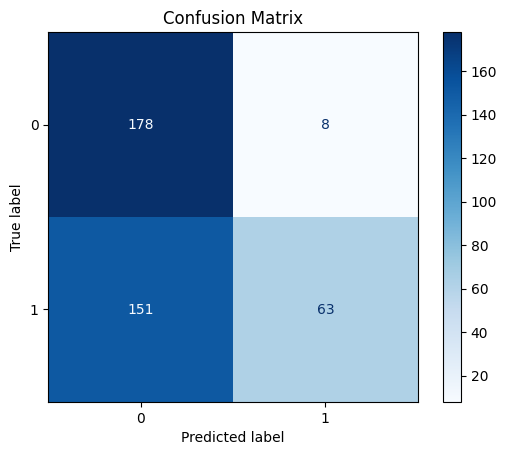

In [ ]:
test_results = engine.test_step(
    model=model,
    dataloader=val_dataloader,
    loss_fn_classification=loss_fn_classification,
    device=device)

per class scores: precision: [0.74807198 0.54545455] | recall: [0.98310811 0.05769231] | f1_score: [0.84963504 0.10434783]
average scores: precision: 0.6467632624444963 | recall: 0.5204002079002079 | f1_score: 0.47699143129165344
accuracy: 0.7425
QWK:  0.057467057101024954


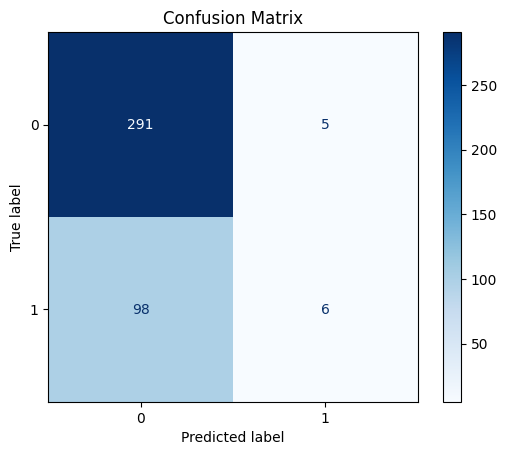

In [ ]:
test_results = engine.test_step(
    model=model,
    dataloader=train_dataloader,
    loss_fn_classification=loss_fn_classification,
    device=device)